In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import CBcm

In [2]:
from scipy import stats

import iminuit

In [3]:
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')

In [4]:
common_settings = pickle.load(open('/home/jp/projects/atm_nu/ddm_results/final_settings/common_settings_daemon.pkl'))

In [5]:
import mufit
reload(mufit)
import mufit_plots as mfp
reload(mfp)

MUFIT: Using quickflux2!
MUFIT: Using quickflux2!
MufitPlots does not use the mceq flux evaluator directly
MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

In [6]:
fitname = 'prd22_daemon_v5'
filename = '/home/jp/projects/atm_nu/ddm_results/'+fitname+'.pkl'

old_fitname = 'prd22_daemon_v3'
old_filename = '/home/jp/projects/atm_nu/ddm_results/'+old_fitname+'.pkl'

In [7]:
fit = mufit.MuFit(datasets = ['bessfull',
                              'l3c', 
                              'opera', 
                              'minos',
                              'cms',
                              'deis',
                              'mutronratio',
                             'deisratio'],

                 flux_splines = 'daemon-v3',)


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Adjusting DEIS name
daemon-v3
('Using errors in mode: ', 'mixed')
MUTRON ratio: adding ALL errors in quadrature
DEIS ratio: adding ALL errors in quadrature


In [8]:
physics_params = common_settings['physics_params']
physics_params

[u'pi+_31G',
 u'pi-_31G',
 u'K+_31G',
 u'K-_31G',
 u'pi+_158G',
 u'pi-_158G',
 u'K+_158G',
 u'K-_158G',
 u'p_158G',
 u'n_158G',
 u'pi+_20T',
 u'pi-_20T',
 u'pi+_2P',
 u'pi-_2P',
 u'K+_2P',
 u'K-_2P',
 u'p_2P',
 u'n_2P',
 u'GSF_1',
 u'GSF_2',
 u'GSF_3',
 u'GSF_4',
 u'GSF_5',
 u'GSF_6']

In [9]:
my_flux_parameters = {}
for onep in physics_params:
    if 'GSF' in onep:
        my_flux_parameters[onep] = [0., False, -4, 4, 0., 1]
    elif ('31G' in onep) or ('158G' in onep):
        my_flux_parameters[onep] = [0., False, -10, 10, 0., 1]
    elif ('20T' in onep) or ('2P' in onep):
        if 'pi+' in onep:
            my_flux_parameters[onep] = [-0.3, False, -5.5, 5.5,  0.,  2.]
        elif 'pi-' in onep:
            my_flux_parameters[onep] = [0,False, -33,  33,    0,  10]
        elif 'K+' in onep:
            my_flux_parameters[onep]= [ 0., False, -19,  19,  0,  10]
        elif 'K-' in onep:
            my_flux_parameters[onep]=[-20., False, -25,  30, 10.,  20.]
        elif 'p' in onep:
            my_flux_parameters[onep]=[12., False, -16, 16,  0., 6]
        elif 'n' in onep:
            my_flux_parameters[onep]=[0., False, -6, 6,   0,  2.5]
#for onep in physics_params:
#    print(onep, my_flux_parameters[onep])
    
mysyst = deepcopy(fit.systematics)
mysyst.update({# Fixing DEIS because errors are included by default
               'deis_mscat':  [0.0, True, -3, 3],
               'deis_bfield':  [0.0, True, -3, 3],
               'deis_norm':  [0.0, True, -3, 3],

               # L3c (all)
               'l3c_align': 0.0042, #np.random.uniform(-3,3),
               'l3c_bfield': -3.30, #np.random.uniform(-3,3),
               'l3c_eloss': -2.92, #np.random.uniform(-3,3),
               'l3c_overb': -0.5, #np.random.uniform(-3,3),
               'l3c_normHor': -1.41, #np.random.uniform(-3,3),
               'l3c_normVert': -1.591, #np.random.uniform(-3,3),
               'l3c_pres': 1.352, #np.random.uniform(-3,3),

               'mn_escale': -1.59, #np.random.uniform(-3,3),

               # Bess
               'bess_align': -1.72, #np.random.uniform(-3,3),
               'bess_finres': 0.2, #np.random.uniform(-3,3),
               })

In [10]:
# Check if there's a previous fit, start from there
if os.path.isfile(old_filename):
    old_result = pickle.load(open(old_filename,'rb'))
    print('Updating starting values')
    for onekey in my_flux_parameters:
        my_flux_parameters[onekey][0] = old_result['params'][onekey]['value']
    for onekey in mysyst:
        if type(mysyst[onekey]) == list:
            mysyst[onekey][0] = old_result['params'][onekey]['value']    
        else:
            mysyst[onekey] = old_result['params'][onekey]['value'] 


Updating starting values


In [11]:
nfits = 1
counter = 0
bestfit = 1E9
defprior = 60
for ifit in range(nfits):
    print 'Internal fit ', ifit
    
    # Start at best fit from previous fit
    if bestfit<1E9:
        for onekey in my_flux_parameters:
            my_flux_parameters[onekey][0] = fit.results['params'][onekey]['value']
        for onekey in mysyst:
            if type(mysyst[onekey]) == list:
                mysyst[onekey][0] = fit.results['params'][onekey]['value']    
            else:
                mysyst[onekey] = fit.results['params'][onekey]['value']  
            
    # Change some parameters slightly
    for i in range(4):
        randkey = my_flux_parameters.keys()[np.random.randint(len(my_flux_parameters))]
        my_flux_parameters[randkey][0] += np.random.normal()
    
    #print(my_flux_parameters)
    
    one_m, one_f = fit.run_fit(
        flux_parameters = my_flux_parameters,        
        exp_parameters = mysyst,
        fit_data = 'all',
        fit_mode = 'physics',
        use_priors = True,
        print_mode = False,
        dry_run = False,
        emin=5.,
        emax=1E9,
        fake_data = False,
        )
    
    this_fit = fit.results['fmin']['fval']
    print 'This fit', this_fit
    if this_fit < bestfit:
        print 'Updated results for fit', this_fit, bestfit
        bestfit = deepcopy(this_fit)
        results = deepcopy(fit.results)
        m = one_m
        f = one_f

Internal fit  0


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit.py:304: RuntimeWarning: invalid value encountered in divide
  phys_priors_mean)**2/phys_priors_err**2)[prior_bool]


Successful fit!
This fit 519.181118497
Updated results for fit 519.181118497 1000000000.0


In [12]:
free_params = 0
for one_param in fit.fit_keys:
    if not fit.minuit_settings['fix_'+one_param]:
        free_params += 1
#print(free_params, len(fit.fit_keys))

In [13]:
all_keys = results['params'].keys()
dof = fit.results['bins']-free_params
print 'Chi2',fit.results['chi2'], '/', dof, 'dof (approximate)'
p_value = 1-stats.chi2.cdf(fit.results['chi2'], dof)
print('P-value', p_value)
syst_keys = []
print '\t'.join(['Param', 'value','error'])
for one_param in physics_params:
    all_keys.remove(one_param)
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])
all_keys.sort()
for one_param in all_keys:
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])



Chi2 424.8814993186991 / 425 dof (approximate)
('P-value', 0.49249846170310974)
Param	value	error
pi+_31G	-2.18	0.78
pi-_31G	-3.21	0.38
K+_31G	-1.94	0.76
K-_31G	-0.28	0.99
pi+_158G	0.14	0.10
pi-_158G	4.17	0.70
K+_158G	0.41	0.98
K-_158G	0.28	0.99
p_158G	0.26	0.95
n_158G	1.97	0.79
pi+_20T	-1.84	0.34
pi-_20T	-5.17	2.24
pi+_2P	-5.17	1.89
pi-_2P	-3.87	7.35
K+_2P	8.68	6.44
K-_2P	-14.15	13.13
p_2P	10.76	5.24
n_2P	3.16	2.26
GSF_1	0.85	0.90
GSF_2	0.41	0.99
GSF_3	0.13	0.99
GSF_4	0.65	0.99
GSF_5	-2.41	0.95
GSF_6	0.62	0.98
bess_align	-1.52	0.67
bess_finres	0.16	0.82
deis_bfield	0.00	0.50
deis_mscat	0.00	0.50
deis_norm	0.00	0.50
l3c_align	0.01	0.12
l3c_bfield	2.79	0.90
l3c_eloss	2.56	0.89
l3c_normHor	-2.22	0.46
l3c_normVert	-2.09	0.46
l3c_overb	-0.60	0.75
l3c_pres	0.99	0.45
mn_escale	-1.65	0.32


In [14]:
#minos_errors = one_m.minos()

In [15]:
one_f

------------------------------------------------------------------
| FCN = 519.2                   |    Ncalls=4927 (4927 total)    |
| EDM = 4.19E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------
| 0 | K+_2P        |     9     |     6     |            |            |   -19   |   19    |       |
| 1 | p_2P         |    11     |     5     |            |            |   -16   |   16    |       |
| 2 | pi-_158G     |    4.2    |    0.7    |            |            |   -10   |   10    |       |
| 3 | pi+_2P       |   -5.2    |    1.9    |            |            |  -5.5   |   5.5   |       |
| 4 | K-_2P        |    -14    |     13    |            |            |   -25   |   30    |       |
| 5 | K-_31G       |   -0.28   |    0.99   |            |            |   -10   |   10    |       |
| 6 | n_158G       |    2.0    |    0.8    |            |            |   -10   |   10    |       |
| 7 | pi+_31G      |   -2.2    |    0.8    |            |            |   -10   |   10    |       |
| 8 | K+_158G      |    0.4    |    1.0    |            |            |   -10   |   10    |       |
| 9 | K-_158G      |   0.28    |   0.99    |            |            |   -10   |   10    |       |
| 10| pi-_20T      |   -5.2    |    2.2    |            |            |   -33   |   33    |       |
| 11| pi+_158G     |   0.14    |   0.10    |            |            |   -10   |   10    |       |
| 12| p_158G       |   0.26    |   0.95    |            |            |   -10   |   10    |       |
| 13| GSF_4        |    0.7    |    1.0    |            |            |   -4    |    4    |       |
| 14| GSF_5        |   -2.4    |    1.0    |            |            |   -4    |    4    |       |
| 15| GSF_6        |    0.6    |    1.0    |            |            |   -4    |    4    |       |
| 16| GSF_1        |    0.9    |    0.9    |            |            |   -4    |    4    |       |
| 17| GSF_2        |    0.4    |    1.0    |            |            |   -4    |    4    |       |
| 18| GSF_3        |   0.13    |   0.99    |            |            |   -4    |    4    |       |
| 19| K+_31G       |   -1.9    |    0.8    |            |            |   -10   |   10    |       |
| 20| pi+_20T      |   -1.8    |    0.3    |            |            |  -5.5   |   5.5   |       |
| 21| pi-_31G      |   -3.2    |    0.4    |            |            |   -10   |   10    |       |
| 22| pi-_2P       |    -4     |     7     |            |            |   -33   |   33    |       |
| 23| n_2P         |    3.2    |    2.3    |            |            |   -6    |    6    |       |
| 24| deis_norm    |    0.0    |    0.5    |            |            |   -3    |    3    |  yes  |
| 25| l3c_bfield   |    2.8    |    0.9    |            |            |   -5    |    5    |       |
| 26| l3c_overb    |   -0.6    |    0.8    |            |            |   -5    |    5    |       |
| 27| mn_escale    |   -1.65   |    0.32   |            |            |   -5    |    5    |       |
| 28| bess_align   |   -1.5    |    0.7    |            |            |   -5    |    5    |       |
| 29| l3c_normVert |   -2.1 

In [16]:
fit.results['flux_parameters'] = my_flux_parameters

In [17]:
fit.results['flux_tables']

'daemon-v3'

In [18]:
pickle.dump(fit.results, open(filename, 'wb'))
print('Written', filename)

('Written', '/home/jp/projects/atm_nu/ddm_results/prd22_daemon_v5.pkl')


In [19]:
fit.results['flux_parameters']

{u'GSF_1': [0.8877911059802726, False, -4, 4, 0.0, 1],
 u'GSF_2': [0.3706802040056676, False, -4, 4, 0.0, 1],
 u'GSF_3': [0.11654775919098004, False, -4, 4, 0.0, 1],
 u'GSF_4': [0.5873427560225135, False, -4, 4, 0.0, 1],
 u'GSF_5': [-2.1921881217806907, False, -4, 4, 0.0, 1],
 u'GSF_6': [0.5625895731445238, False, -4, 4, 0.0, 1],
 u'K+_158G': [0.28766612384744583, False, -10, 10, 0.0, 1],
 u'K+_2P': [4.65040161064481, False, -19, 19, 0, 10],
 u'K+_31G': [-1.9576739137902202, False, -10, 10, 0.0, 1],
 u'K-_158G': [-0.13429821934623565, False, -10, 10, 0.0, 1],
 u'K-_2P': [-22.382653840573234, False, -25, 30, 10.0, 20.0],
 u'K-_31G': [-0.2880778434065281, False, -10, 10, 0.0, 1],
 u'n_158G': [2.037567693975273, False, -10, 10, 0.0, 1],
 u'n_2P': [3.688873405533341, False, -6, 6, 0, 2.5],
 u'p_158G': [-0.9540526828892816, False, -10, 10, 0.0, 1],
 u'p_2P': [12.778835349121358, False, -16, 16, 0.0, 6],
 u'pi+_158G': [0.1290448393360073, False, -10, 10, 0.0, 1],
 u'pi+_20T': [-1.89773004437

In [20]:
m.matrix(correlation=True)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|              |        K+_2P         p_2P     pi-_158G       pi+_2P        K-_2P       K-_31G       n_158G      pi+_31G      K+_158G      K-_158G      pi-_20T     pi+_158G       p_158G        GSF_4        GSF_5        GSF_6        GSF_1        GSF_2        GSF_3       K+_31G      pi+_20T      pi-_31G       pi-_2P         n_2P   l3c_bfield    l3c_overb    mn_escale   bess_align l3c_normVert  l3c_normHor    l3c_eloss  bess_finres     l3c_pres    l3c_align |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        K+_2P |        1.000        0.025        0.022       -0.198        0.874        0.000       -0.003       -0.007       -0.092        0.030       -0.237        0.137        0.013        0.012       -0.029       -0.001       -0.103        0.005       -0.000       -0.026       -0.324        0.006       -0.044       -0.027       -0.045        0.001        0.023        0.057        0.013        0.001       -0.043        0.003        0.250       -0.157 |
|         p_2P |        0.025        1.000       -0.129        0.041        0.056        0.004       -0.168        0.044        0.006        0.000       -0.337       -0.217       -0.057       -0.008        0.029       -0.003       -0.051       -0.006       -0.002        0.059       -0.378        0.127       -0.020       -0.131        0.060       -0.005       -0.008       -0.095       -0.076       -0.059        0.053        0.009       -0.023        0.031 |
|     pi-_158G |        0.022       -0.129        1.000        0.068        0.003        0.022       -0.477        0.087        0.030       -0.081        0.292        0.714       -0.142       -0.017        0.057        0.002       -0.288       -0.010       -0.003        0.107        0.295        0.220        0.123       -0.042       -0.014        0.089        0.009        0.158        0.088        0.049       -0.015       -0.042       -0.064        0.035 |
|       pi+_2P |       -0.198        0.041        0.068        1.000       -0.059       -0.002        0.049       -0.026        0.047       -0.017       -0.084        0.062        0.006        0.030       -0.109        0.036       -0.077        0.016        0.003       -0.035       -0.025       -0.077        0.228        0.060        0.057        0.029       -0.089       -0.031       -0.050       -0.047        0.048       -0.009        0.022        0.034 |
|        K-_2P |        0.874        0.056        0.003       -0.059        1.000       -0.001        0.056       -0.021        0.091       -0.046       -0.416       -0.062        0.003        0.022       -0.091        0.038       -0.074        0.016        0.004       -0.011       -0.317       -0.072       -0.288        0.080       -0.040       -0.006       -0.006        0.038       -0.000       -0.009       -0.038        0.007        0.246       -0.154 |
|       K-_31G |        0.000        0.004        0.022       -0.002       -0.001        1.000       -0.029        0.013       -0.000        0.001       -0.004        0.010       -0.008        0.000       -0.001        0.000        0.006        0.000        0.000        0.012       -0.007       -0.295       -0.

In [21]:
fit.results['cov_params'] = m.list_of_vary_param()
ordered_matrix = np.zeros_like(fit.results['corr_matrix'])
# Need to reorder this business
syst_params = ['l3c_bfield','l3c_overb','l3c_normVert', 'bess_align','bess_finres',
               'l3c_normHor','l3c_eloss','l3c_pres','l3c_align', 'mn_escale']
syst_params.sort()
ordered_phys = np.zeros(len(physics_params))
ordered_syst = np.zeros(len(syst_params))
for ip, one_param in enumerate(physics_params):
    ordered_phys[ip] = fit.results['cov_params'].index(one_param)
for ip, one_param in enumerate(syst_params):
    ordered_syst[ip] = fit.results['cov_params'].index(one_param)
    
full_list = physics_params + syst_params
full_in = np.array(np.concatenate((ordered_phys, ordered_syst)),dtype=int)
for j, one_param in enumerate(full_list):
    for k in range(len(full_in)):
        ordered_matrix[j,k] = fit.results['corr_matrix'][full_in[j], full_in[k]]

In [22]:
if not os.path.exists('/home/jp/projects/atm_nu/ddm_results/'+fitname):
    os.mkdir('/home/jp/projects/atm_nu/ddm_results/'+fitname)

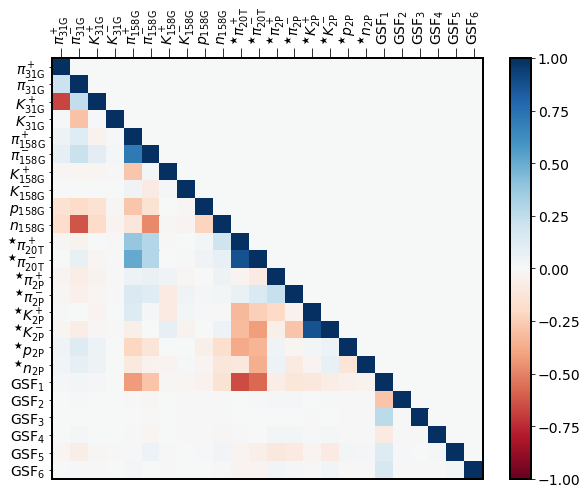

In [23]:
maxb = len(physics_params)
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]

    
fig = plt.figure(figsize=(12*0.7,10*0.7))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
plt.tight_layout()



fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_daemon5.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_daemon5.pdf')


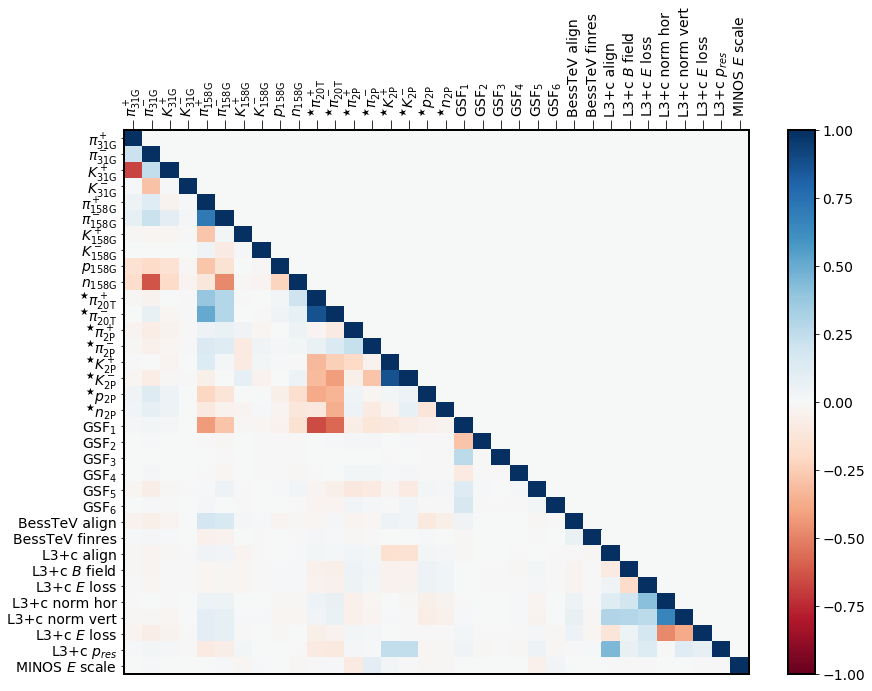

In [24]:
maxb = None
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full_daemon5.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full_daemon5.pdf')


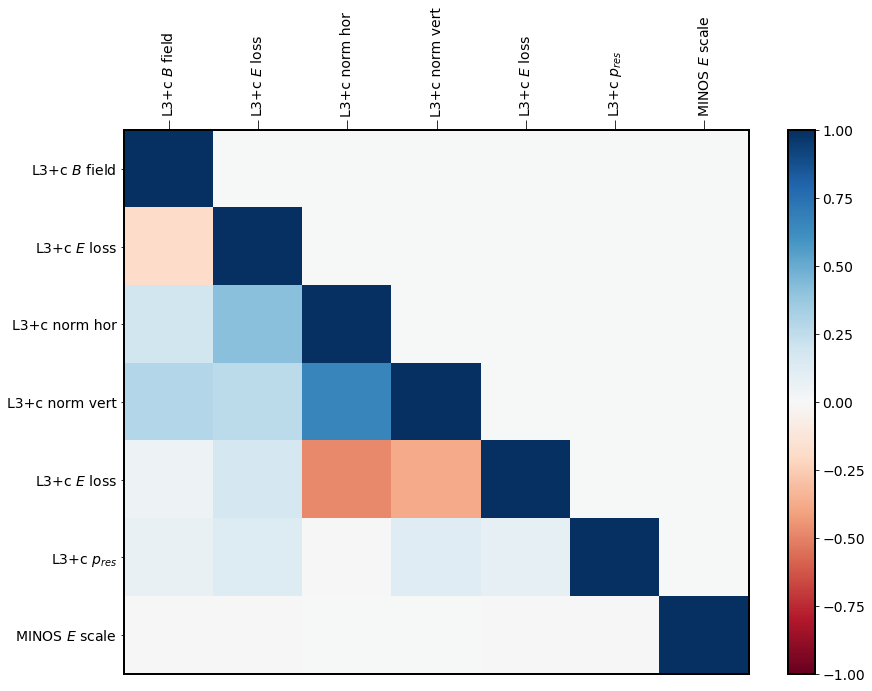

In [25]:
inb = 27
maxb = None
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix[inb:maxb,inb:maxb].shape[0], 1.)
plt.pcolor(corr_matrix[inb:maxb,inb:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[inb:maxb], rotation=90)
plt.yticks(xmarks, params[inb:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst_daemon5.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst_daemon5.pdf')


MufitPlots does not use the mceq flux evaluator directly
Flux deis 87.7076 [3.85253885e-01 5.31407677e-01 2.17502999e+00 9.38873735e+00
 5.09392229e+00 1.12260294e+01 8.81416862e+00 7.37088517e+00
 3.76010987e+00 5.00448064e+00 3.24277286e+00 3.76537956e+00
 9.03784336e-01 3.81922339e-01 1.07686726e+00 2.40805482e-01
 1.46744573e+00 2.23026490e-03 2.34337301e-01 7.99032595e-01
 1.29722772e+00 1.20854637e+00 2.04239431e-02 7.94210657e-01
 2.89201799e-02 1.03159335e-03]


/home/jp/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Flux l3c 38.0475 [ 0.07890747  0.1855273   0.13140244  0.4185145   0.04198531  0.0243552
  0.81529746  0.48452077 13.67408384]
Pull sum 306.21809879233547 118.66340052636365


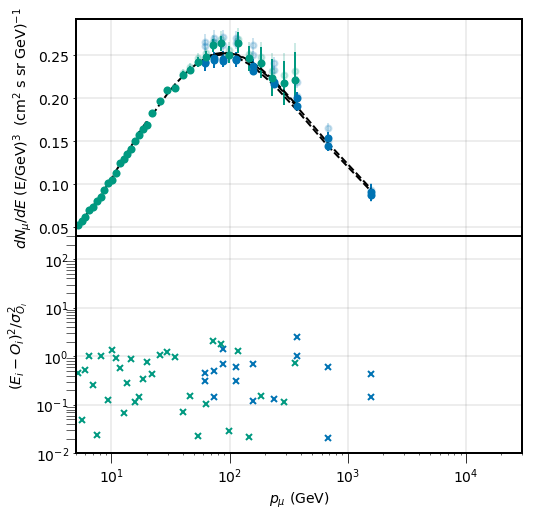

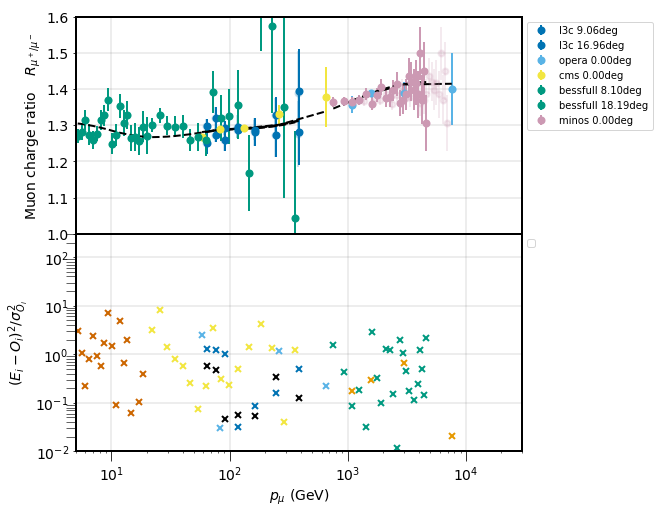

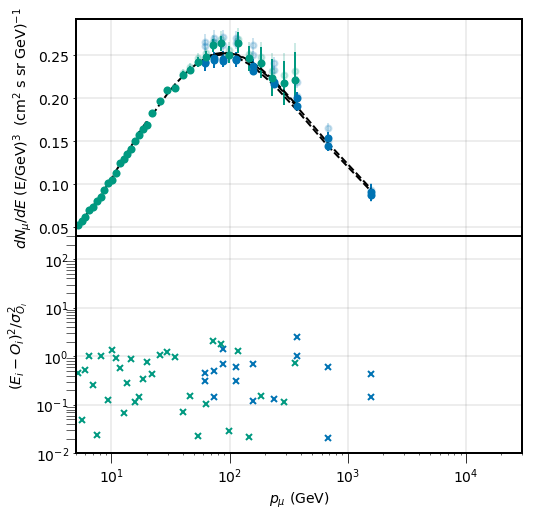

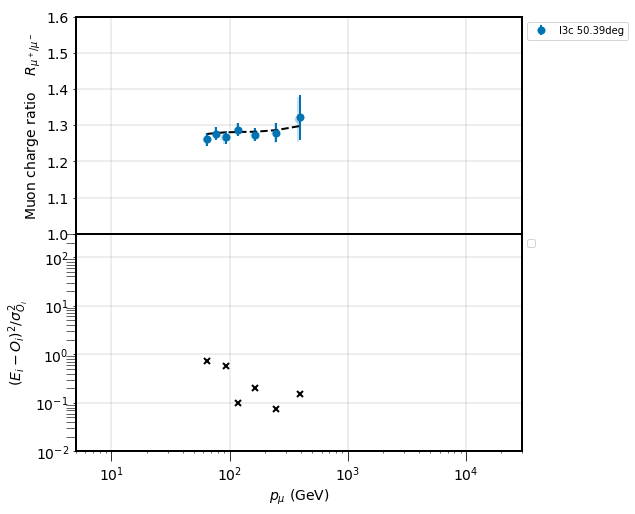

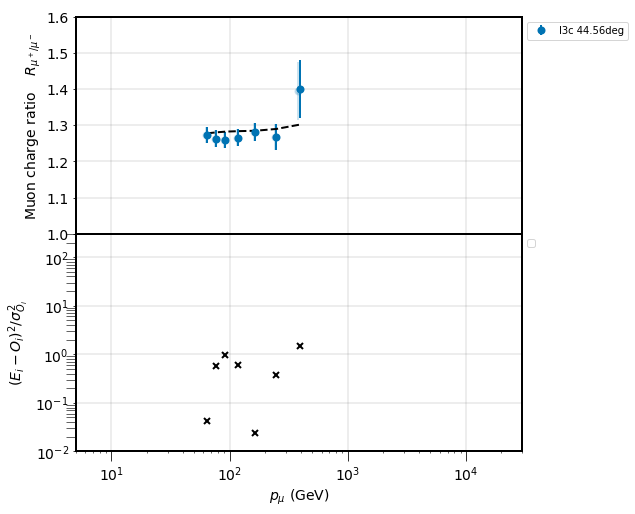

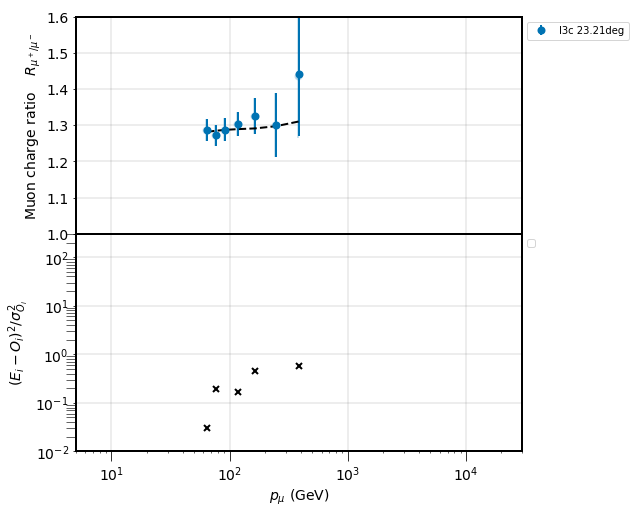

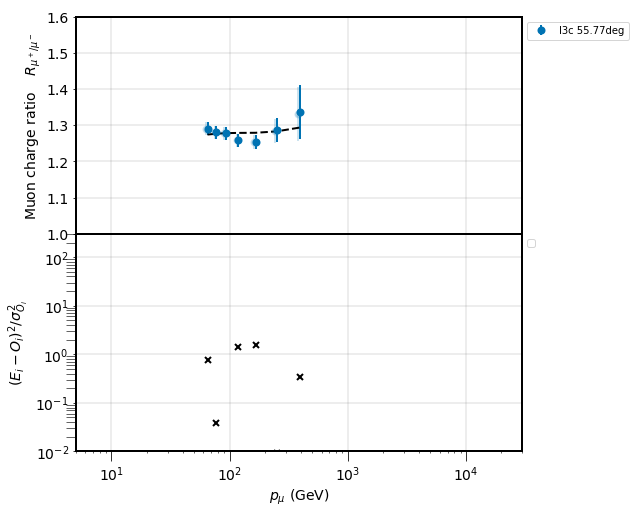

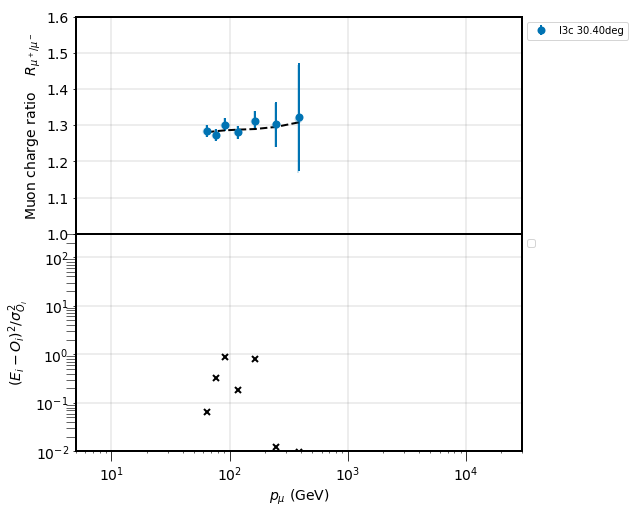

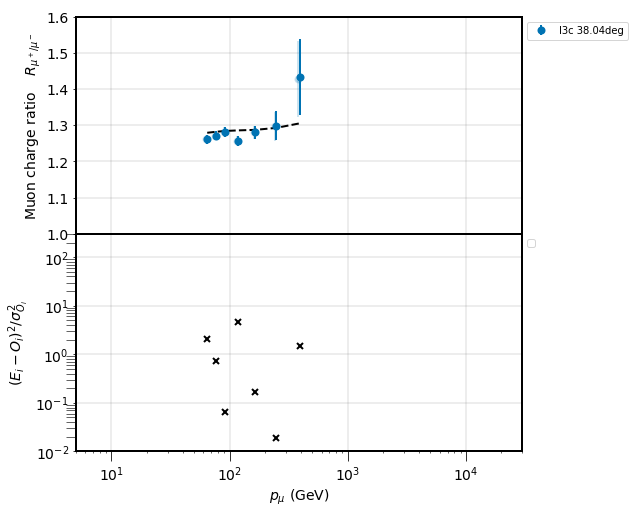

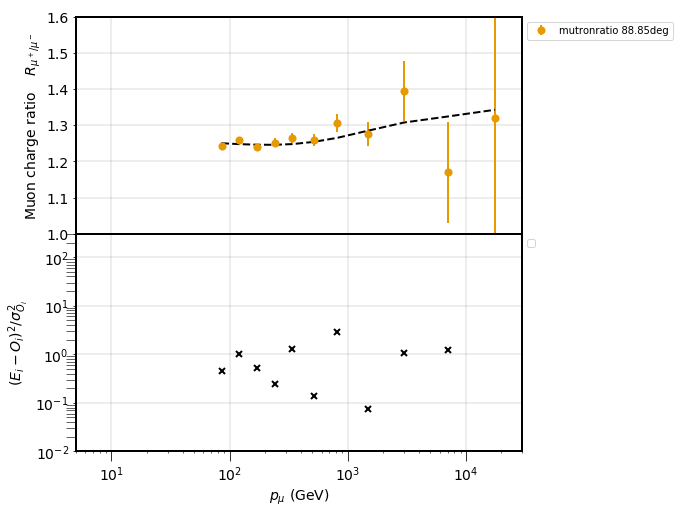

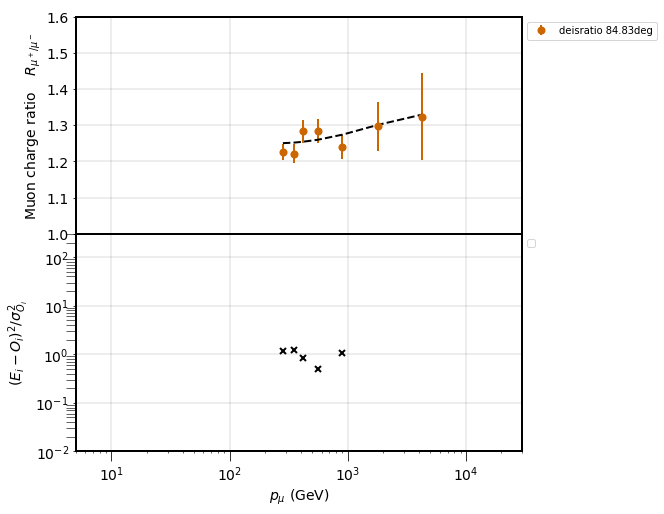

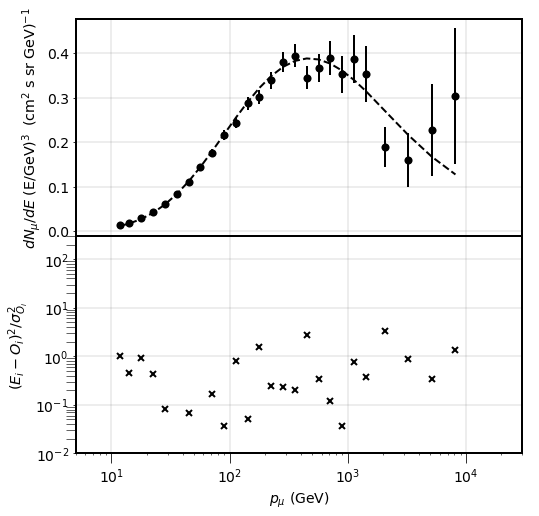

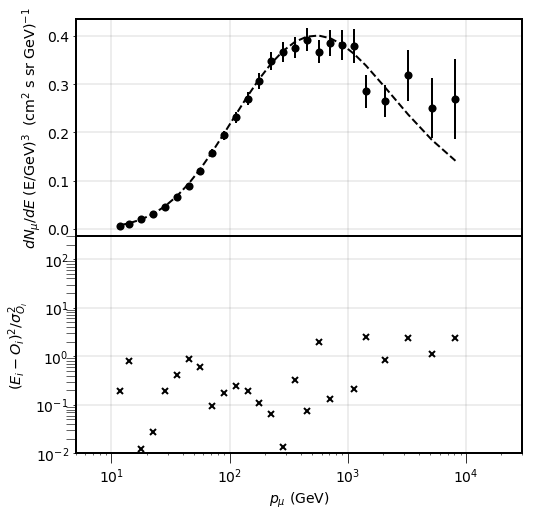

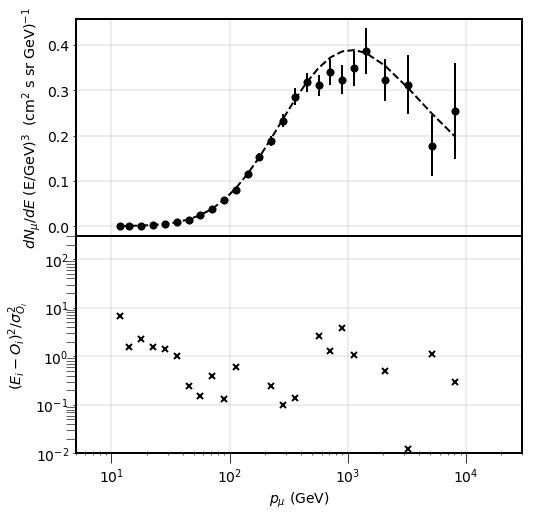

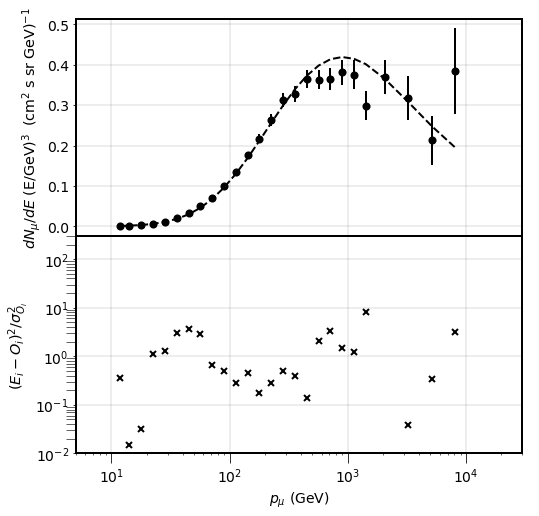

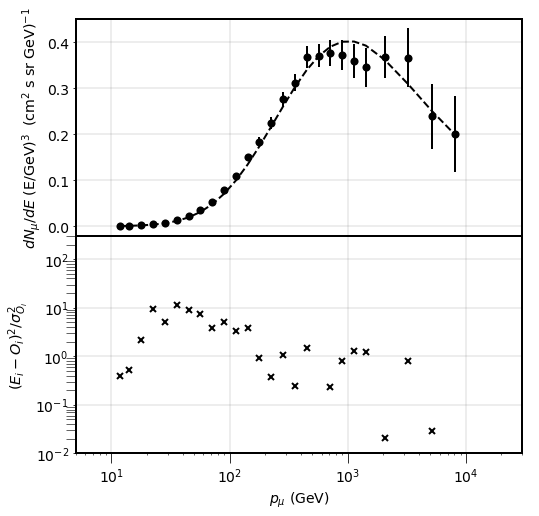

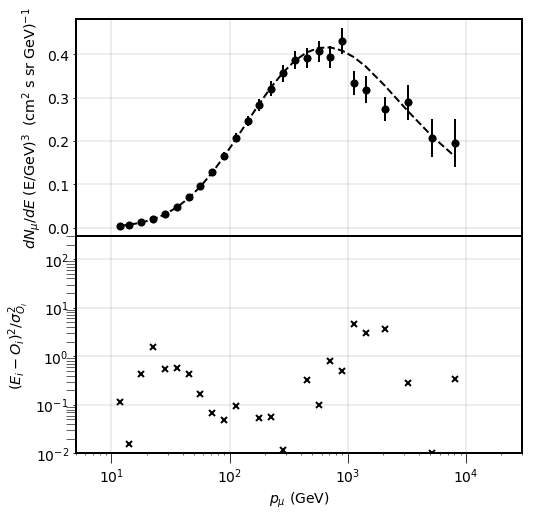

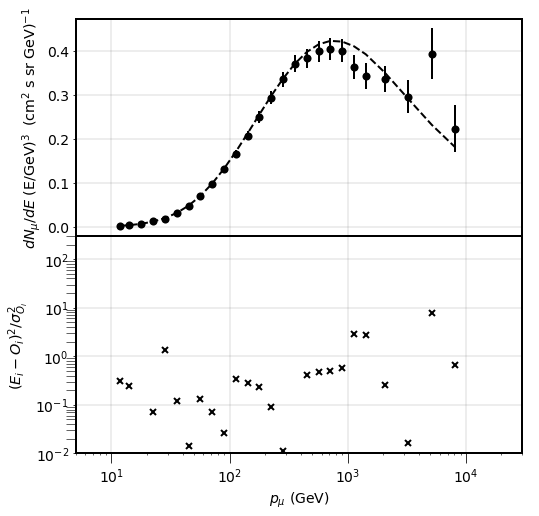

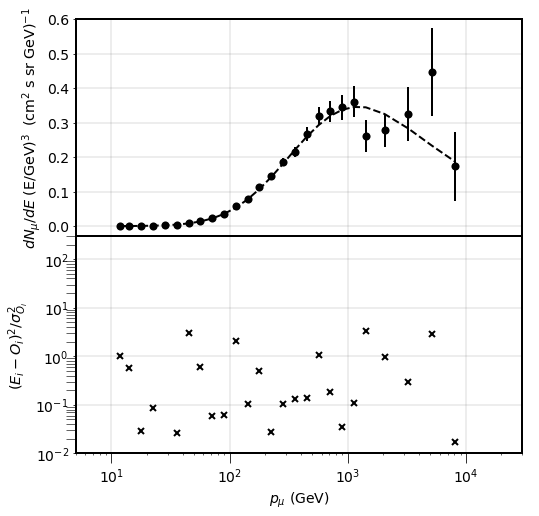

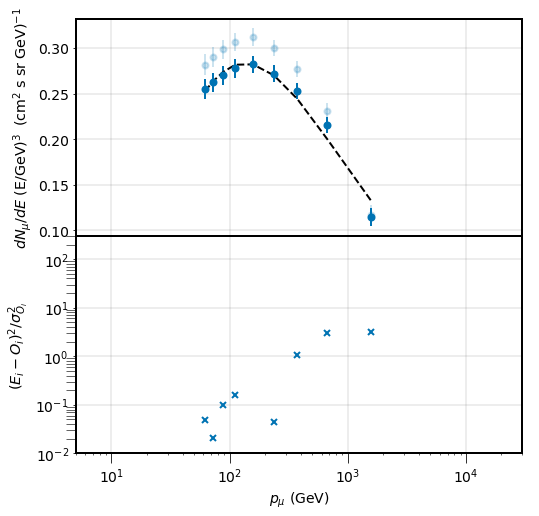

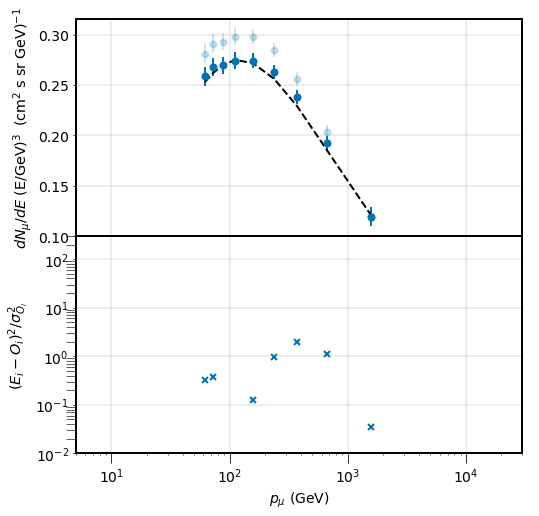

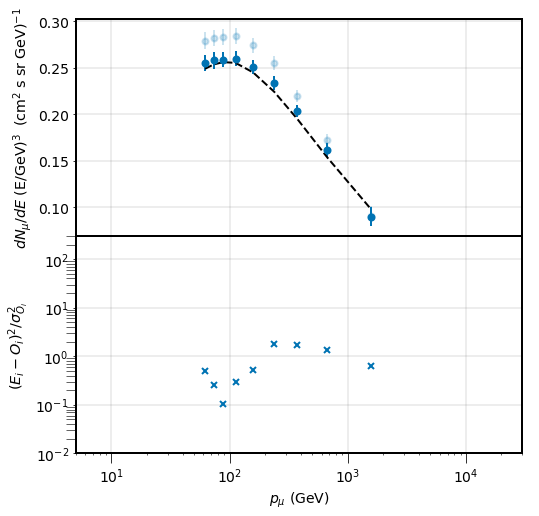

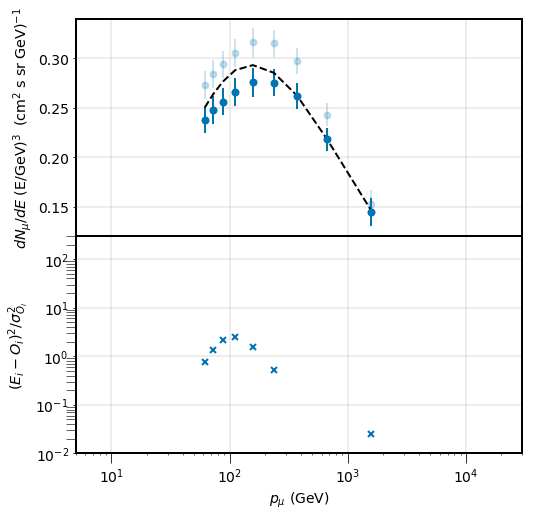

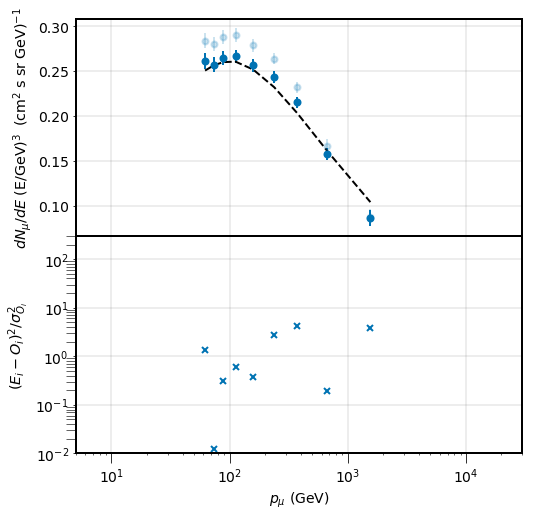

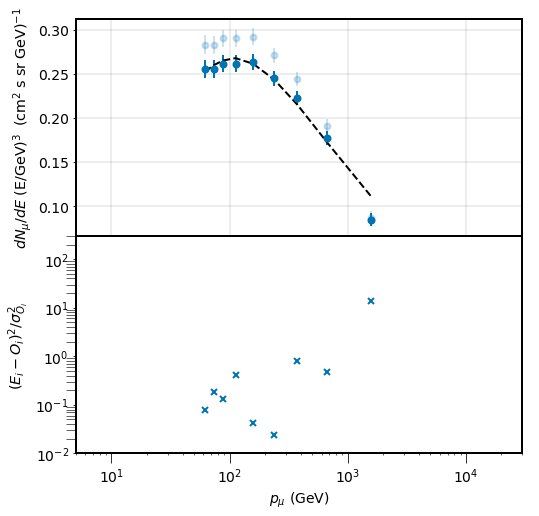

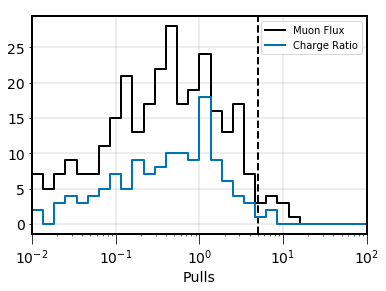

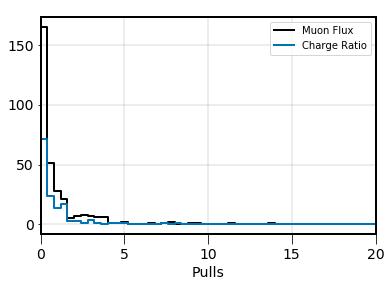

In [26]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
mfp.plot_comparison(fit, pullflag=10.,
                   emin=5)

In [27]:
reload(mfp)

MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

 Figure with the following coszen angles [0.   0.05 0.1  0.15 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 5
l3c 44.5613 0.7777414039689492 6
l3c 23.2197 0.4052602163253273 9
l3c 55.7711 0.9733893224590094 4
l3c 30.4015 0.5306062725450561 8
l3c 9.0687 0.15827867387560976 11
l3c 16.9617 0.29603751173552223 10
l3c 38.0475 0.6640541471525425 7
bessfull 8.1096 0.14153922101973215 11
bessfull 18.1949 0.31756091207111625 10


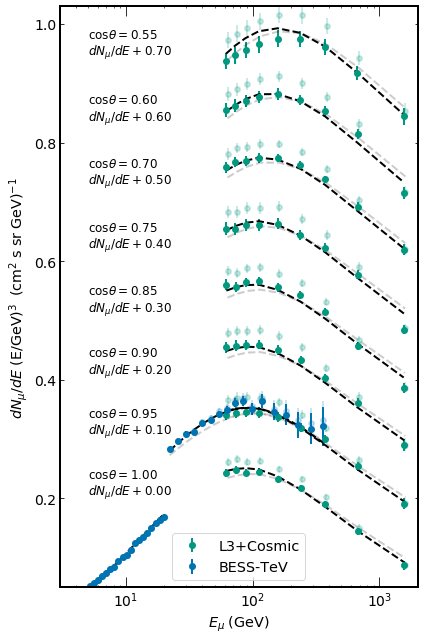

In [28]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
f1 = mfp.plotICRC21(fit, data_prefit = True)
f1.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_vert_daemon5.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.   0.05 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 3
l3c 44.5613 0.7777414039689492 4
l3c 23.2197 0.4052602163253273 7
l3c 55.7711 0.9733893224590094 2
l3c 30.4015 0.5306062725450561 6
l3c 9.0687 0.15827867387560976 9
l3c 16.9617 0.29603751173552223 8
l3c 38.0475 0.6640541471525425 5
mutronratio 88.8540 1.5507948535670415 0
opera 0.0000 0.0 9
deisratio 84.8364 1.4806745055389174 1
cms 0.0000 0.0 9
bessfull 8.1096 0.14153922101973215 9
bessfull 18.1949 0.31756091207111625 8
minos 0.0000 0.0 9


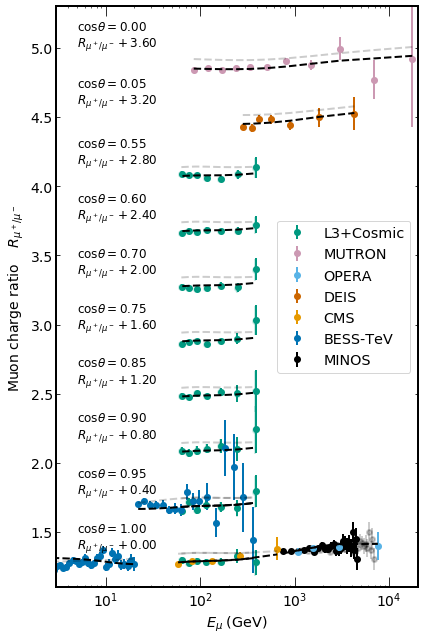

In [29]:
reload(mfp)
f2 = mfp.plotICRC21(fit, data= 'ratio',data_prefit = True)
f2.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/ratio_vert_daemon5.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.01  0.025 0.035 0.055 0.085 0.115 0.16  0.19  1.   ]
deis 79.0472 0.19000027075775947 7
deis 80.7931 0.16000006510032283 6
deis 89.4270 0.010000569911261043 0
deis 88.2809 0.029999453593602104 1
deis 86.5602 0.059999777566286064 3
deis 87.7076 0.03999925401622205 2
deis 84.8364 0.08999987674362474 4
deis 83.1079 0.11999995530721862 5


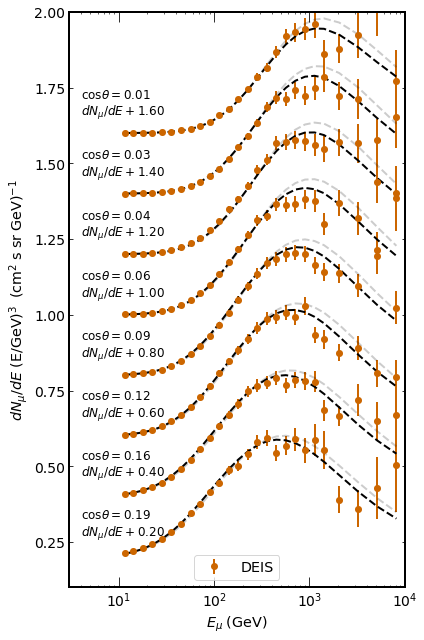

In [30]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
f3 = mfp.plotICRC21(fit, data='deis', data_prefit = True)
f3.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_deis_daemon5.pdf')

MufitPlots does not use the mceq flux evaluator directly


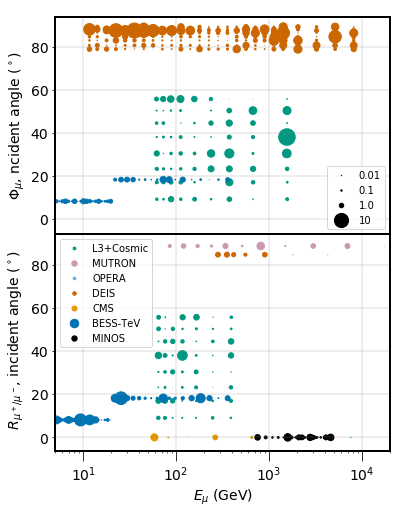

In [31]:
reload(mfp)
f1 = mfp.plotPulls(mufit=fit, pull_scale=20, log_pulls=False
                  )